In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import librosa

import scipy
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas

tqdm.pandas()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.svm import SVC
from sklearn import svm, metrics
from sklearn.utils import shuffle

from sklearn.model_selection import learning_curve


### 모델 설명
- 각 음성데이터에서 mfcc로 추출된 40가지 특징들의 평균, 표준편차, 왜도, 최댓값, 최솟값, 중앙값으로 피쳐 생성
- 프레임의 크기는 25ms, hop은 10ms 로 지정하여 전처리 시행
- 각 학습데이터와 테스트 데이터는 섞지 않은 상태로 학습 진행 후 결과 도출
- 음성의 길이는 각각 다르므로 프레임의 크기를 맞추어 자르는 방식도 있지만, 가장 작은 음성의 길이로 맞춘 뒤, 프레임을 같은 크기로 나눔.

# 01 데이터 전처리

In [4]:
def train_dataset():
    file_path = 'fmcc_train.ctl'
    dataset = []
    with open(file_path) as f:
        lines = f.readlines()
    train_files_names = [i.strip("\n") for i in lines] # \n값 제거
    
    for train_file in train_files_names:
        file_name='raw16k/train/' + train_file + ".wav"
        audio, sr = librosa.load(file_name, sr=16000)
        # 남/녀 별로 labeling
        # 1 : 남자 , 0: 여자
        if "M" in train_file[0]:
            #dataset.append([audio, "male"])
            dataset.append([file_name, audio, "male"])
        elif "F" in train_file[0]:
            #dataset.append([audio, "feml"])
            dataset.append([file_name, audio, "feml"])
    
    print("TrainDataset 생성 완료")
    return pd.DataFrame(dataset,columns=['fname', 'data','label'])


def test_dataset():
    file_path = 'fmcc_test900_ref.txt'
    dataset = []
    with open(file_path) as f:
        lines = f.readlines()
    test_files_names = [i.strip("\n") for i in lines] # \n값 제거
    for test_file in test_files_names:
        test_file = test_file.split(" ")
        #fname = 'raw16k/test/' + test_file[0]
        fname = test_file[0]
        audio, sr = librosa.load('raw16k/test/' + fname + ".wav", sr=16000)
        if test_file[1] == "feml":
            #dataset.append([fname+".raw", audio, "feml"])
            dataset.append(['/home/wikim/exp/raw16k/test/'+fname+".raw", audio, "feml"])
        elif test_file[1] == "male":
            #dataset.append([fname+".raw", audio, "male"])
            dataset.append(['/home/wikim/exp/raw16k/test/'+fname+".raw", audio, "male"])
    
    print("TestDataset 생성 완료")
    return pd.DataFrame(dataset, columns=['fname','data','label'])


# 음성의 길이 중 가장 작은 길이를 구합니다.

def get_min(data):

    min_data = 9999999
    for i in data:
        if len(i) < min_data:
            min_data = len(i)

    return min_data


def get_max(data):

    max_data = -999
    for i in data:
        if len(i) > max_data:
            max_data = len(i)

    return max_data

def set_length(data, min_length):

    result = []
    for i in data:
        result.append(i[:min_length])
    result = np.array(result)

    return result

def zero_pad(data, max_length):
    padded_data = []
    for d in data:
        if len(d) < max_length:
            pad_width = max_length - len(d)
            padded_d = np.pad(d, (0, pad_width), mode='constant')
        else:
            padded_d = d[:max_length]
        padded_data.append(padded_d)
    return np.array(padded_data)

In [5]:
train_wav = train_dataset()
test_wav = test_dataset()

TrainDataset 생성 완료
TestDataset 생성 완료


In [6]:
train_x = np.array(train_wav.data)
test_x = np.array(test_wav.data)

train_max = get_max(train_x)
test_max = get_max(test_x)

max_data = np.max([train_max, test_max])
print('가장 긴 길이 :', max_data)

가장 긴 길이 : 39040


In [7]:
train_x = zero_pad(train_x, max_data)
test_x = zero_pad(test_x, max_data)
print(train_x[0])
print('train :', train_x.shape) #(데이터셋 개수, 음성 길이)
print('test :', test_x.shape)

[ 0.         -0.00064087 -0.00036621 ...  0.          0.
  0.        ]
train : (10000, 39040)
test : (900, 39040)


# 02 특징 추출

In [10]:
def preprocess_dataset(data):
    mfccs = []
    for i in data:
        mfcc = librosa.feature.mfcc(y=i,sr=16000,n_mfcc=40,   # n_mfcc:return 될 mfcc의 개수를 정해주는 파라미터, 더 다양한 데이터 특징을 추출하려면 값을 증가시키면 됨. 일반적으로 40개 추출
                                                  n_fft=400,  # n_fft:frame의 length를 결정하는 파라미터 
                                                  hop_length=160) # hop_length의 길이만큼 옆으로 가면서 데이터를 읽음(10ms기본)
        features = extract_features(mfcc, i, 16000)
        mfccs.append(feature)
    return pd.DataFrame(mfccs)
    #return np.array(mfccs)
    
# 특징 추출 함수 정의
def extract_features(mfcc, y, sr):
    features = {
        'meanfreq': librosa.feature.spectral_bandwidth(y=y, sr=sr),
        'sd': librosa.feature.spectral_contrast(y=y, sr=sr),
        'median': librosa.feature.spectral_rolloff(y=y, sr=sr),
        'Q25': librosa.feature.spectral_centroid(y=y, sr=sr),
        'Q75': librosa.feature.spectral_flatness(y=y),
        'IQR': librosa.feature.mfcc(y=y, sr=sr),
        'skew': librosa.feature.rmse(y=y),
        'kurt': librosa.feature.zero_crossing_rate(y),
        'sp.ent': librosa.feature.tonnetz(y),
        'sfm': librosa.feature.poly_features(y),
        'centroid': librosa.feature.tempogram(y),
        'meanfun': librosa.feature.zero_crossing_rate(y),
        'minfun': librosa.feature.spectral_rolloff(y=y, sr=sr),
        'maxfun': librosa.feature.spectral_bandwidth(y=y, sr=sr),
        'meandom': librosa.feature.spectral_contrast(y=y, sr=sr),
        'mindom': librosa.feature.spectral_flatness(y=y),
        'maxdom': librosa.feature.spectral_centroid(y=y, sr=sr),
        'dfrange': librosa.feature.rmse(y=y),
        'modindx': librosa.feature.zero_crossing_rate(y),
    }
    return features


In [11]:
train_mfccs = preprocess_dataset(train_x)
#train_mfccs = np.array(train_mfccs)

test_mfccs = preprocess_dataset(test_x)
#test_mfccs = np.array(test_mfccs)

#train_mfccs.head()

AttributeError: No librosa.feature attribute rmse

In [10]:
# 데이터셋 재설정하기
train_set = pd.DataFrame()
train_set['fname'] = train_wav['fname']
test_set = pd.DataFrame()
test_set['fname'] = test_wav['fname']

train_set = pd.concat([train_set,train_mfccs],axis=1)
train_set['label'] = train_wav['label']
test_set = pd.concat([test_set,test_mfccs],axis=1)
test_set['label'] = test_wav['label']

In [11]:
shuffle_train=shuffle(train_set, random_state = 20)
shuffle_test=shuffle(test_set, random_state = 30)
shuffle_train

,fname,0,1,2,3,4,5,6,7,8,...,9791,9792,9793,9794,9795,9796,9797,9798,9799,label
9957,raw16k/train/MLWS0/MLWS0_pbw1158.wav,-340.279999,-319.469788,-321.478333,-323.552002,-325.117920,-340.695007,-360.244751,-385.219635,-384.449554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
1687,raw16k/train/FJYJ1/FJYJ1_pbw1088.wav,-243.454285,-253.382156,-255.794922,-251.328857,-268.862457,-270.967194,-261.371918,-260.865417,-250.122711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,feml
2116,raw16k/train/FKEJ0/FKEJ0_pbw1117.wav,-452.835297,-443.617828,-454.529083,-458.200867,-487.246490,-481.331848,-496.856873,-506.302948,-504.795349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,feml
231,raw16k/train/FGBS0/FGBS0_pbw1032.wav,-430.351044,-396.328156,-397.207031,-387.942505,-402.910583,-400.541595,-394.241272,-405.073914,-417.138000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,feml
2780,raw16k/train/FLGH0/FLGH0_pbw1181.wav,-268.635345,-249.424744,-228.871628,-225.276352,-214.906647,-206.776642,-198.894623,-210.790924,-215.549133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,feml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,raw16k/train/FLSH1/FLSH1_pbw1116.wav,-331.727173,-311.308472,-314.836609,-309.803864,-316.015656,-314.702698,-307.348328,-322.848846,-309.810944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,feml
9620,raw16k/train/MLWJ1/MLWJ1_pbw1021.wav,-286.912506,-257.790741,-249.507294,-249.536011,-210.922867,-197.607346,-178.165115,-199.741699,-180.210815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
7068,raw16k/train/MJSG0/MJSG0_pbw1069.wav,-438.635284,-421.745850,-409.365875,-385.705475,-391.160980,-362.075348,-365.659912,-354.657684,-347.104218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
7391,raw16k/train/MJST0/MJST0_pbw1192.wav,-252.588943,-208.159775,-208.322144,-216.950012,-224.177795,-221.013977,-228.688919,-238.187302,-228.476761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male


In [12]:
print(train_set.shape)
print(test_set.shape)

(10000, 9802)
(900, 9802)


In [13]:
def convert_to_labels(preds, i2c, k=2):
    ans = []
    ids = []
    for p in preds:
        idx = np.argsort(p)[::-1]
        ids.append([i for i in idx[:k]])
        ans.append(' '.join([i2c[i] for i in idx[:k]]))

    return ans, ids

In [186]:
X = train_set.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)  # 특징 번호 리스트

X = X.values  # 특징벡터 값 전체


# 라벨값 문자열 -> int 변환 (PCA 적용시 변환 필요)
labels= np.sort(np.unique(train_set.label.values))  # 라벨 이름 가져오기

num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i  # feml, male -> index = 0 or 1로 변환
    i2c[i] = c  # 0 or 1 -> feml, male 변환
    
y=np.array([c2i[x] for x in train_set.label.values])
y_test=np.array([c2i[x] for x in test_set.label.values])
print(y)

[0 0 0 ... 1 1 1]


In [14]:
X = shuffle_train.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)  # 특징 번호 리스트

X = X.values  # 특징벡터 값 전체


# 라벨값 문자열 -> int 변환 (PCA 적용시 변환 필요)
labels= np.sort(np.unique(shuffle_train.label.values))  # 라벨 이름 가져오기

num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    print("i = ", i, ", c = ", c)
    c2i[c] = i  # feml, male -> index = 0 or 1로 변환
    i2c[i] = c  # 0 or 1 -> feml, male 변환
    
y=np.array([c2i[x] for x in shuffle_train.label.values])
y_test=np.array([c2i[x] for x in shuffle_test.label.values])
print(y)

i =  0 , c =  feml
i =  1 , c =  male
[1 0 0 ... 1 1 0]


In [ ]:
X_test = test_set.drop(['label', 'fname'], axis=1)
X_test = X_test.values

In [15]:
X_test = shuffle_test.drop(['label', 'fname'], axis=1)
X_test = X_test.values

In [16]:
print(X.shape)
print(X_test.shape)

(10000, 9800)
(900, 9800)


In [17]:
# PCA를 적용하기 위한 scaling(정규화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_scaled.shape

(10000, 9800)

In [18]:
#차원축소를 위한 LDA 적용 
lda_components = 1   # LDA의 구성 요소 개수

lda = LinearDiscriminantAnalysis(n_components=lda_components)
X_lda = lda.fit_transform(X_scaled, y)

X_test_lda = lda.transform(X_test_scaled)

In [27]:
# 차원축소를 위한 PCA 적용 
pca = PCA(n_components=1500).fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(sum(pca.explained_variance_ratio_))
X_pca

0.9100066220635199


array([[-2.4703994 , -1.4388593 ,  8.650852  , ...,  0.18011945,
         0.34008694,  0.16748874],
       [-1.7060648 , -0.639249  ,  3.212101  , ..., -0.68547964,
         0.70372796,  0.7278491 ],
       [-1.1628335 , -0.51647586,  3.009104  , ...,  0.3662851 ,
         0.1424865 ,  0.23818183],
       ...,
       [-1.965316  , -1.034346  ,  5.296126  , ...,  0.4303124 ,
        -1.1826857 , -0.4678933 ],
       [-2.6734788 , -1.8036952 ,  8.923252  , ..., -0.53338563,
         2.045601  , -0.513074  ],
       [-1.0847927 , -1.048129  ,  5.2243104 , ...,  0.73449206,
        -0.66947937, -1.1425419 ]], dtype=float32)

In [28]:
# 기존 트레인셋을 분할하여 정확도 테스트
# Fit an SVM model
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 30, shuffle = True)

clf = svm.SVC() # 93.5
#clf.fit(X_pca, train_labels)
#clf = SVC(kernel = 'linear', probability=True)  # 90.6
#clf = SVC(kernel = 'rbf', C = 4, gamma = 0.01, probability=True)  # 93.3
clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_val), y_val))

0.951


In [22]:
# 기존 트레인셋을 분할하여 정확도 테스트
# Fit an SVM model
X_train, X_val, y_train, y_val = train_test_split(X_lda, y, test_size = 0.2, random_state = 30, shuffle = True)

clf = svm.SVC() # 93.5
#clf.fit(X_pca, train_labels)
#clf = SVC(kernel = 'linear', probability=True)  # 90.6
#clf = SVC(kernel = 'rbf', C = 4, gamma = 0.01, probability=True)  # 93.3
clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_val), y_val))

0.999


In [29]:
clf = SVC(kernel = 'linear', C=4, probability=True)  # 90.6
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_val), y_val))

0.913


In [30]:
clf = SVC(kernel = 'rbf', C = 4, gamma = 0.01, probability=True)  # 93.3
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_val), y_val))

0.4815


In [31]:
clf = SVC(kernel = 'linear', C=0.1, probability=True)  # 90.6
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_val), y_val))

0.913


In [33]:
clf = svm.SVC(probability=True)

model = clf.fit(X_pca, y)
str_preds, _ = convert_to_labels(clf.predict_proba(X_test_pca), i2c, k=2)
#print(str_preds)
print(accuracy_score(clf.predict(X_test_pca), y_test))

0.9355555555555556


In [21]:
def plot_learning_curve(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation Score')

    plt.legend(loc='best')
    plt.show()
    
    
def plot_loss_curve(estimator, X, y, train_sizes, cv):
    train_sizes, train_losses, test_losses = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='neg_mean_squared_error')

    train_losses_mean = -np.mean(train_losses, axis=1)
    train_losses_std = np.std(train_losses, axis=1)
    test_losses_mean = -np.mean(test_losses, axis=1)
    test_losses_std = np.std(test_losses, axis=1)

    plt.figure()
    plt.title('Loss Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Loss')

    plt.grid()

    plt.fill_between(train_sizes, train_losses_mean - train_losses_std,
                     train_losses_mean + train_losses_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_losses_mean - test_losses_std,
                     test_losses_mean + test_losses_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_losses_mean, 'o-', color='r', label='Training Loss')
    plt.plot(train_sizes, test_losses_mean, 'o-', color='g', label='Cross-validation Loss')

    plt.legend(loc='best')
    plt.show()


In [22]:
estimator = svm.SVC(probability=True)  # 학습에 사용할 모델 또는 추정기
X = X_pca  # 학습 데이터
y = y # 레이블
train_sizes = np.linspace(0.1, 1.0, 10)  # 학습 데이터 크기를 10개로 분할
cv = 5  # 교차검증을 위한 폴드 수

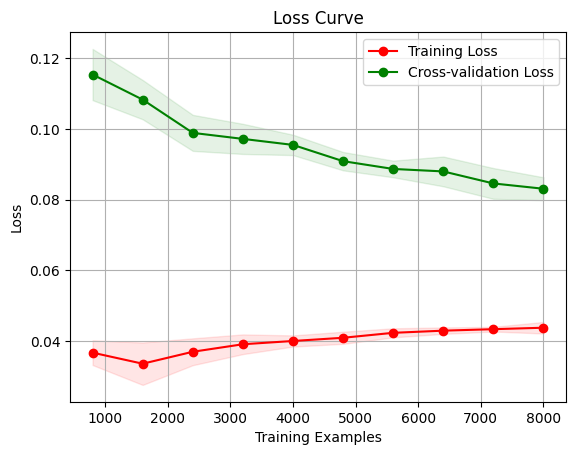

In [23]:
plot_loss_curve(estimator, X, y, train_sizes, cv=5)

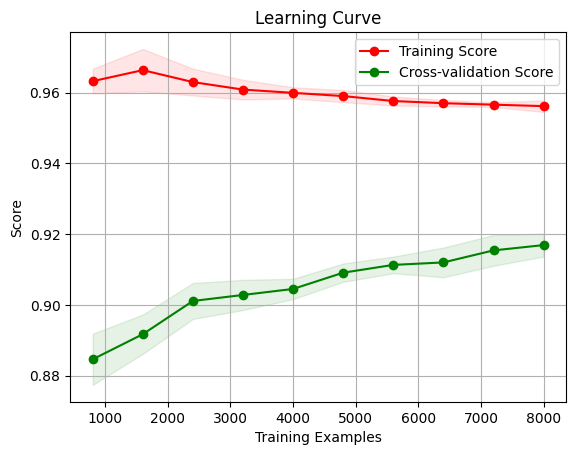

In [24]:
plot_learning_curve(estimator, X, y, train_sizes, cv)

# SVM 모델 학습

In [24]:
def to_df_test(y_pred, test_wav):
    predict_df = pd.DataFrame()
    pred_name=[]
    for i in range(len(y_pred)):
        if(y_pred[i] == 0):
            pred_name.append("male")
        elif(y_pred[i] == 1):
            pred_name.append("feml")
    
    predict_df["data"] = test_wav["fname"]
    predict_df["label"] = pred_name
    #predict_df = predict_df.data
        
    return predict_df

def to_txt_test(predict_df):
    predict_df.to_csv('강력한컴공_test_results.txt', sep = " ", index=False, header=False, lineterminator='\n')
    

In [39]:
C=100
clf = svm.LinearSVC(C=C, max_iter = 10000)
clf.fit(X_pca, y)

print(accuracy_score(clf.predict(X_test_pca), y_test))
y_pred = clf.predict(X_test_pca)
#predict_df = to_df_test(y_pred, test_wav)
#to_txt_test(predict_df)


0.9122222222222223


In [26]:
clf = svm.SVC()
clf.fit(X_pca, train_labels)

print(accuracy_score(clf.predict(X_test_pca), test_labels))
y_pred = clf.predict(X_test_pca)
predict_df = to_df_test(y_pred, test_wav)
to_txt_test(predict_df)



0.5633333333333334


In [27]:
C=8
clf = svm.LinearSVC(C=C, max_iter = 10000)
clf.fit(X_pca, train_labels)

print(accuracy_score(clf.predict(X_test_pca), test_labels))
y_pred = clf.predict(X_test_pca)
predict_df = to_df_test(y_pred, test_wav)
to_txt_test(predict_df)


0.5944444444444444


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [77]:
# polynomial 활용

clf = svm.SVC(kernel = 'poly', degree = 3, gamma = 'auto', C=C, max_iter = 10000)    
#3차항으로 설정, degree = 3
#gamma는 sigma^2에 해당하는 scale parameter
#학습 반복횟수 10000

clf.fit(X_pca, train_labels)

print(accuracy_score(clf.predict(X_test_pca), test_labels))
y_pred = clf.predict(X_test_pca)
predict_df = to_df_test(y_pred, test_wav)
to_txt_test(predict_df)


0.9066666666666666


In [78]:
C=4
clf = svm.LinearSVC(C=C, max_iter = 10000)
clf.fit(X_pca, train_labels)

print(accuracy_score(clf.predict(X_test_pca), test_labels))
y_pred = clf.predict(X_test_pca)
predict_df = to_df_test(y_pred, test_wav)
to_txt_test(predict_df)


0.9233333333333333


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [79]:
# 함수 정의
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [80]:
# 데이터 로드하기
X = X_pca[:, :2]
y = train_labels
X.shape

(10000, 2)

In [82]:
# 모델 정의&피팅
C = 1.0 #regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

In [84]:
# plot title 형성
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC',
          'SVC with polynomial (degree 3) kernel')

In [ ]:
# plot 그리기

fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()